In [7]:
import numpy as np
import cv2

%matplotlib inline
import matplotlib.pyplot as plt


cv2.__version__

'4.2.0'

In [8]:
def ImageBinarization(im1):
    
    threshold = 150
    
    for i in range(len(im1)):
        for j in range(len(im1[i])):
            if im1[i][j] > threshold: 
                im1[i][j] = 255
            else:
                im1[i][j] = 0
    
    return im1



def  RemoveNoise(im1):
    ## 水平一列を走査して閾値より小さければ除去
    #WARN: ドットも消える可能性あり
    
    threshold_px = 50
    
    #TODO: ネストが深くて見にくい、要修正
    for i in range(len(im1)):
        count_horizon = 0
        for j in range(len(im1[i])):
            if im1[i][j] > 10:
                count_horizon +=1
                
        if count_horizon < threshold_px:
            for j in range(len(im1[i])):
                im1[i][j] = 0
                
    return im1


def CropImage(im1):
    width = 500
    height = 100
    
    hmin = len(im1)
    hmax = 0
    wmin = len(im1[0])
    wmax = 0
    
    #TODO: 読みにくい！
    for i in range(len(im1)):
        for j in range(len(im1[i])):
            if(im1[i][j]) > 100:
                if i < hmin: hmin = i
                if i > hmax: hmax = i
                if j < wmin: wmin = j
                if j > wmax: wmax = j
                    
    hnew_min  = (hmax + hmin) // 2 - height // 2
    hnew_max = (hmax + hmin) // 2 + height // 2
    wnew_min = (wmax + wmin) // 2 - width // 2
    wnew_max =(wmax + wmin) // 2 + width // 2

    
    blank = np.zeros((height, width, 3), np.uint8)
    plt.imsave("img_fix/fix01.jpg", blank)
    im2 = cv2.imread("img_fix/fix01.jpg", 0)

    for i in range(height):
        for j in range(width):
                im2[i][j] = im1[hnew_min+i][j]
   
    return im2


def padding_position(x, y, w, h, p):
    return x - p, y - p, w + p * 2, h + p * 2


In [9]:
def DivideDigits(path):
    #FIXIT: findContoursのために切り抜いた画像を保存する手間をかけている(fix01.png)
    #TODO: 出力の時に矩形領域も見えるようにすべき

    #これ以下の領域は削除、ヒューリスティック、画像によって変えるべき
    min_size = 400
    
    
    imgray = cv2.imread(path, 0)
    forcrop_img = imgray
    contoured_img = imgray

    contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    crops = []

    for c in contours:
        if cv2.contourArea(c) < min_size:
            continue

      # rectangle area
        x, y, w, h = cv2.boundingRect(c)
        x, y, w, h = padding_position(x, y, w, h, 5)

        # crop the image
        cropped = forcrop_img[y:(y + h), x:(x + w)]
        cropped = ImageBinarization(cropped)
        crops.append(cropped)

#        cv2.drawContours(contoured, c, -1, (0, 0, 255), 3)  # contour
        cv2.rectangle(contoured_img, (x, y), (x + w, y + h), (0, 255, 0), 3)  #rectangle contour

    return crops


def DetectVerticle(img, numarea, segments, starth, startw, len_detector, thresh_px):
    ##垂直方向の検出
    
    num_px = 0
    for h in range(starth, starth + len_detector):
        w = startw
        if img[h][w]  > 0:
            num_px += 1
            if num_px > thresh_px:
                segments[numarea] = 1
                return segments

    return segments

def DetectHorizon(img, numarea, segments, starth, startw, len_detector, thresh_px):
    ##水平方向の検出
    num_px = 0
    for w in range(startw, startw + len_detector):
        h = starth
        if img[h][w]  > 0:
            num_px += 1
            if num_px > thresh_px:
                segments[numarea] = 1
                return segments

    return segments


def RecognizeNumber(digit_img):
    #HACK: 1だけ横幅が小さいことを利用する
    if len(digit_img[0]) < 35:
        return 1
    
    len_detector = 10
    thresh_px = 4

    segments = [0, 0, 0, 0, 0, 0, 0]


    #多めに減らしておく(detectorの初期位置になるため)
    w_AGD = len(digit_img[0]) // 2 
    w_BC    = len(digit_img[0]) // 4 * 3
    w_FE     = len(digit_img[0]) // 4 - 4

    h_BF   = len(digit_img) // 3
    h_CE   = len(digit_img) // 3 * 2
    h_A      = 6
    h_G      = len(digit_img) //2 - 5
    h_D      = len(digit_img) - 15
    
    #TODO: もっとスマートに書けるか？ 見栄えが悪い
    segments = DetectVerticle(digit_img, 0, segments,  h_A,   w_AGD, len_detector, thresh_px)  #A
    segments = DetectHorizon(digit_img, 1, segments, h_BF,     w_BC, len_detector, thresh_px)  #B
    segments = DetectVerticle(digit_img, 2, segments,  h_CE,     w_BC, len_detector, thresh_px)  #C
    segments = DetectHorizon(digit_img, 3, segments,  h_D,     w_AGD, len_detector, thresh_px)  #D
    segments = DetectHorizon(digit_img, 4, segments, h_CE,     w_FE, len_detector, thresh_px)  #E
    segments = DetectHorizon(digit_img, 5, segments, h_BF,     w_FE, len_detector, thresh_px)  #F
    segments = DetectVerticle(digit_img, 6, segments, h_G,     w_AGD, len_detector, thresh_px)  #G
    
    
    
    #WARN: 7の条件に注意(fを含むか?)
    if segments == [1, 1, 1, 1, 1, 1, 0]: return 0
    if segments == [1, 1, 0, 1, 1, 0, 1]: return 2
    if segments == [1, 1, 1, 1, 0, 0, 1]: return 3
    if segments == [0, 1, 1, 0, 0, 1, 1]: return 4
    if segments == [1, 0, 1, 1, 0, 1, 1]: return 5
    if segments == [1, 0, 1, 1, 1, 1, 1]: return 6
    if segments == [1, 1, 1, 0, 0, 1, 0]: return 7
    if segments == [1, 1, 1, 1, 1, 1, 1]: return 8
    if segments == [1, 1, 1, 1, 0, 1, 1]: return 9

    return "Error"

def SortNumbers(digits_img):
    nums = []
    for i in range(len(digits_img)):
        num = RecognizeNumber(digits_img[i])
        nums.append(num)

    nums.reverse()
    
    return nums


def PlotMultiImages(images, row = 1):
    #TODO: サイズの調整(y軸に合わせる等)
    col = len(images)

    plt.figure(figsize = (20,20))

    for i in range(1, len(images)+1):
        plt.subplot(row, col, i)

        plt.imshow(images[len(images)-i], cmap = "gray")
        plt.axis("off")

    plt.tight_layout()

[1, 2, 3, 4, 5, 6, 7, 8]


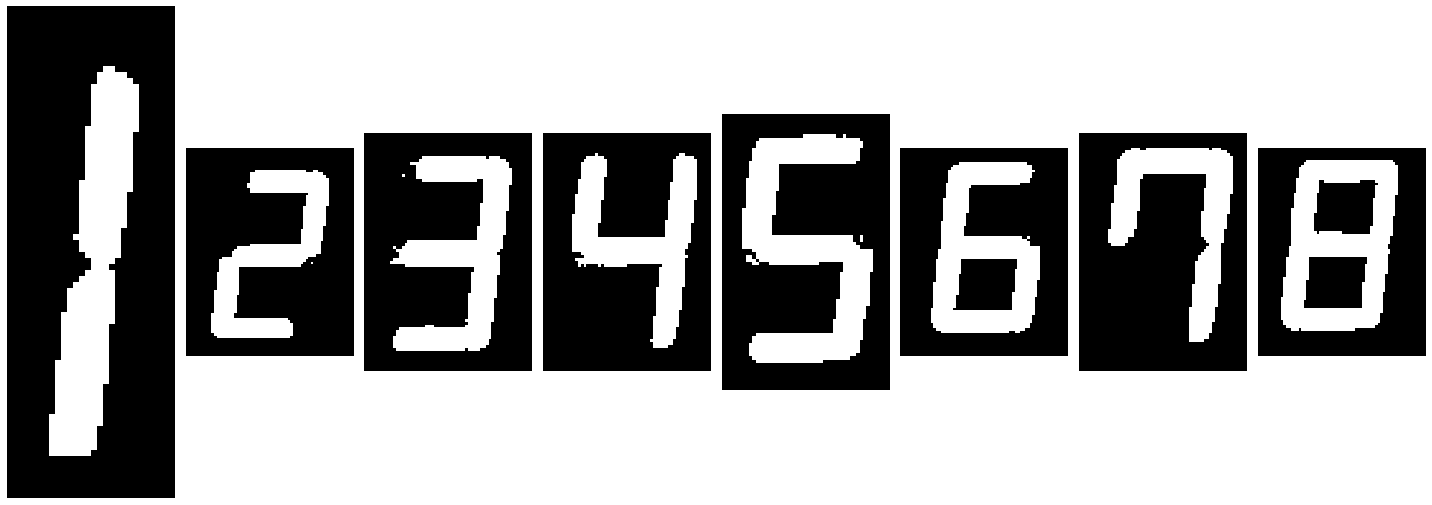

In [19]:
#TODO: 各変換前後をプロットする(matplotlibのsubplot?)
#TODO: 部分テストの実装

path_read = "img_test/test01.jpg"
path_fixed_out = "img_fix/fix01.jpg"

#TODO: 見つからなかった場合の例外処理
im1 = cv2.imread(path_read, 0)

im1_bin = ImageBinarization(im1)
im1_removed_noise = RemoveNoise(im1_bin)
im2 = CropImage(im1_removed_noise)


#FIXIT: 保存してから読み込んでいるがもっとスマートにできそう
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imsave(path_fixed_out, im2)

digits_img = DivideDigits(path_fixed_out)
nums = SortNumbers(digits_img)

#plt.plot(digits_img)

print(nums)
PlotMultiImages(digits_img)

In [ ]:
#|====A====|
#| F                   | B
#|                      |
#|====G====|
#|                      | 
#| E                   | C
#|====D====|    

In [ ]:
import time
start_time = time.time()

elapsed_time = time.time() - start_time
print("処理時間: {:.4}[s]".format(elapsed_time))